# The M5 Competition: Forecasting Sales
<b>Annie Tran<br>
<b>June 2020

# Abstract

This competition was a sprint for me mainly because I was late to the game and only had one week to work on it, but to my surprise, I ended up ranking in the top 1%. I don't think that would have been possible without the Kaggle community and the countless hours I spent on digging and shuffling through the data. The purpose of this notebook is to document as well as think through what I've done restrospectively.

Before we get started, here some some brief descriptions of the competition:
- The main objective is to forecast sales for various products by 28 days.
- We will be using hierarchical sales data aggregated at different levels starting at item level and aggregated to that of departments, product categories, stores in three geographical areas of the US: California, Texas, and Wisconsin
- Besides the time series data, it also includes explanatory variables such as price, promotions, day of the week, and special events (e.g. Super Bowl, Valentine’s Day, and Orthodox Easter) that affect sales which are used to improve forecasting accuracy.

For more details on the competition, please follow these links:
- https://mofc.unic.ac.cy/m5-competition/
- https://www.kaggle.com/c/m5-forecasting-accuracy/overview

# Results

- Using moving average as the baseline model, I achieved a wrmsse of 0.73
- After adding lagged features and a few external data sources such as Walmart stock and US unemployment rate, the wrmsse was reduced to 0.57. This was trained using Light GBM.
- With more time, I think the score could be further improved by using hyperparameter tuning and analyzing feature contribution using Shapley or regression.

# Reference

I looked at the following notebooks + discussions for inspirations and implementation of the cost function:
- https://www.kaggle.com/girmdshinsei/for-japanese-beginner-with-wrmsse-in-lgbm#data%E5%8A%A0%E5%B7%A5-(data-transform)
- https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration
- https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834
- https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133468#888822

# Outline
<b> 1. </b> [Load Data](#Read-in-Data) <br>
<b> 2. </b> [Exploratory Data Analysis](#EDA) <br>
<b> 3. </b> [Data Preprocessing](#Data-Prep) <br>
<b> 4. </b> [Feature Engineering](#Feature-Engineering) <br>
<b> 5. </b> [WRMSSE](#Evaluation-Metric) <br>
<b> 6. </b> [Model: Moving Average](#Baseline-Model-(Moving-Average)) <br>
<b> 7. </b> [Model: Light GBM](#Light-GBM) <br>

# Imports

In [1]:
import os
import gc
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import datetime
import random
from itertools import cycle

from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder
import scipy
from scipy.sparse import csr_matrix
import statsmodels as sms
import statsmodels.tsa.stattools as smtsa
import lightgbm as lgb

from ray.tune.schedulers import ASHAScheduler
from ray.tune.utils import pin_in_object_store, get_pinned_object
import ray
from ray import tune

In [2]:
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
pd.set_option('display.max_columns',200)

# Read in Data

In [3]:
calendar = pd.read_csv('calendar.csv')

zf = zipfile.ZipFile('sell_prices.csv.zip')
sell_prices = pd.read_csv(zf.open('sell_prices.csv'))

zf = zipfile.ZipFile('sales_train_validation.csv.zip')
sales_train_val = pd.read_csv(zf.open('sales_train_validation.csv'))

zf = zipfile.ZipFile('sales_train_evaluation.csv.zip')
sales_train_eval = pd.read_csv(zf.open('sales_train_evaluation.csv'))

zf = zipfile.ZipFile('sample_submission.csv.zip')
submission = pd.read_csv(zf.open('sample_submission.csv'))

product = sales_train_val[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

In [4]:
# combine validation and evaluation datasets

missing_days = sorted(list(set([d for d in sales_train_eval.columns if 'd_' in d]) -  set([d for d in sales_train_val.columns if 'd_' in d])))
sales_train_eval = sales_train_eval[['id'] + missing_days]
sales_train_eval['id'] = sales_train_eval['id'].str.replace('evaluation','validation')
sales_train = sales_train_val.merge(sales_train_eval, on='id', how='left')

del sales_train_eval
del sales_train_val
gc.collect()

28

In [5]:
sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,...,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,1,1,2,0,4,0,1,0,1,4,2,0,2,0,1,1,0,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,0,0,0,0,2,0,1,0,0,1,1,1,0,2,3,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,2,3,0,2,0,0,2,2,0,0,2,1,2,1,1,1,2,...,2,1,0,0,0,2,0,5,4,2,1,1,2,3,0,6,0,0,0,1,0,1,5,3,1,0,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5,2,2,2,1,0,0,0,3,0,0,0,3,1,1,1,1,2,1,0,0,1,0,2,1,1,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [6]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [7]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# EDA

In [8]:
print('calendar', calendar.shape)
print('sell_prices', sell_prices.shape)
print('sales_train', sales_train.shape)

calendar (1969, 14)
sell_prices (6841121, 4)
sales_train (30490, 1947)


### Prices Across Stores

- Pricing pattern for a some items seems pretty consistent across most stores
- Also seeing cases where price of an item has different patterns across stores
- Some items vary more in prices compared to others
- Some items have a steep drop in price for a short window of time before spiking back up
- Most items starts rolling out at the same time across stores but there are cases where they get introduced at different times

FOODS_3_697


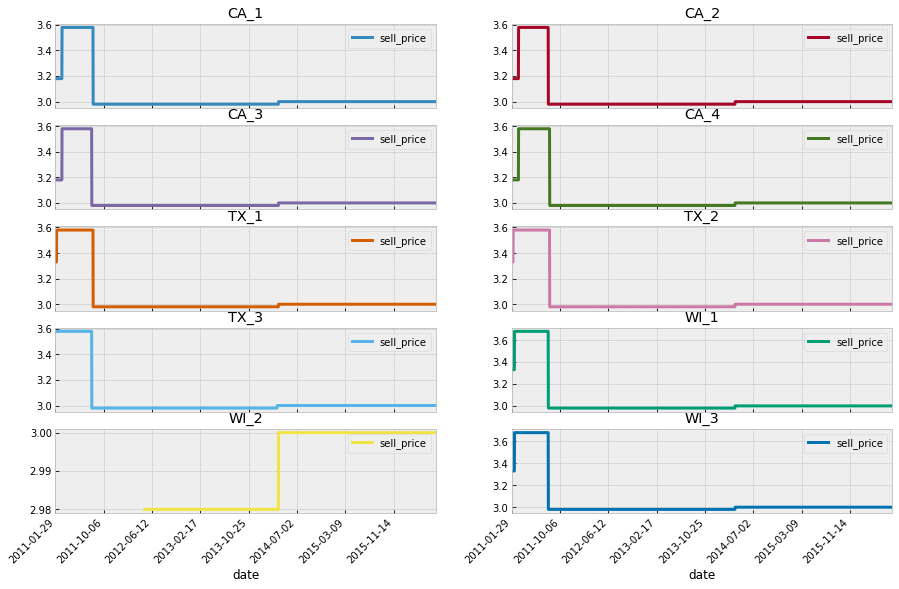

In [9]:
# price over time for a random item with lots of purchases by store

days = [d for d in sales_train.columns if 'd_' in d]
#item_list = sales_train.groupby('item_id')[days].sum().sum(axis=1).sort_values(ascending=False).index
item_list = pd.unique(sales_train['item_id'])

stores = pd.unique(sell_prices.store_id)

full_dates = pd.DataFrame()
for store in stores:
    dates = calendar[['date', 'wm_yr_wk']].drop_duplicates()
    dates['store_id'] = store
    full_dates = full_dates.append(dates)

item = random.choice(item_list)
print(item)
prices = sell_prices[sell_prices.item_id==item]
prices = pd.merge(full_dates, prices[['store_id','wm_yr_wk','sell_price']], on=['store_id', 'wm_yr_wk'], how='left')

fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0

stores = pd.unique(prices.store_id)
for store in stores:
    subset = prices[prices.store_id==store][['date','sell_price']].set_index('date')
    subset.plot(alpha=1, ax=axes[ax_idx], title=store, lw=3, color=next(color_cycle))
    ax_idx += 1

fig.autofmt_xdate(rotation=45)

### Prices across categories, states, and departments

- Prices for food and hobbies are increasing while household decreased and showing signs of going back up since 2014
- Prices are higher in CA and WI
- Food prices are slightly higher in WI
- The bimodal shapes for these distributions can be seen in the drops/spikes in prices in the time series plots as well
- Prices are siginificantly different between departments

In [10]:
sell_prices['cat_id'] = sell_prices['item_id'].str.split('_').str.get(0)
prices = sell_prices.groupby(['cat_id','wm_yr_wk']).mean().reset_index()
week_date_maps = calendar.groupby('wm_yr_wk')['date'].min().reset_index()
prices = prices.merge(week_date_maps[['wm_yr_wk','date']])

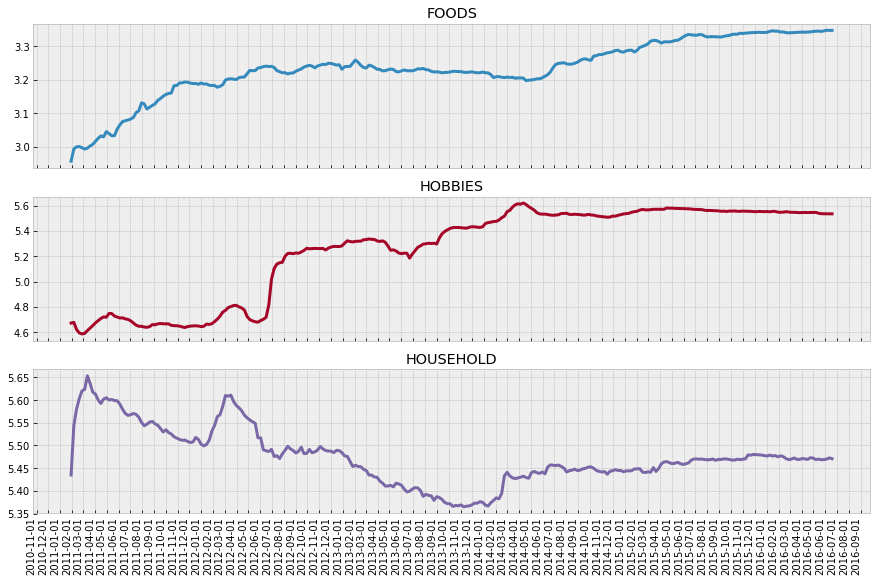

In [11]:
# price over time by category

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0

cats = pd.unique(prices.cat_id)
for cat in cats:
    subset = prices[prices.cat_id==cat][['date','sell_price']]
    subset['date'] = pd.to_datetime(subset['date'])
    subset = subset.set_index('date')

    axes[ax_idx].plot(subset.index.values, subset.sell_price, alpha=1, lw=3, color=next(color_cycle))
    axes[ax_idx].set_title(cat)

    ax_idx += 1

date_form = DateFormatter("%Y-%m-%d")
axes[ax_idx-1].xaxis.set_major_formatter(date_form)
axes[ax_idx-1].xaxis.set_major_locator(mdates.MonthLocator())

fig.autofmt_xdate(rotation=90)

In [12]:
sell_prices['state'] = sell_prices['store_id'].str.split('_').str.get(0)
sell_prices['dept'] = sell_prices['item_id'].str[:-4]

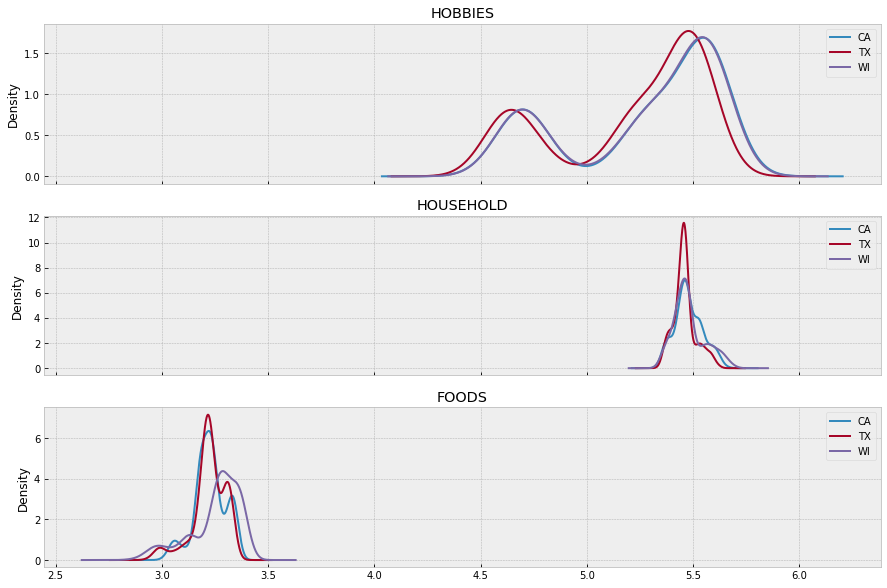

In [13]:
# Distribution of price per state per catgory

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0

cats = pd.unique(sell_prices.cat_id)
for cat in cats:
    subset = sell_prices[sell_prices.cat_id==cat].copy()
    subset = subset.groupby(['state', 'wm_yr_wk'])['sell_price'].mean().reset_index()
    for state in pd.unique(subset['state']):
        subset[subset['state']==state]['sell_price'].plot.density(alpha=1, ax=axes[ax_idx], title=cat, label=state)
        axes[ax_idx].legend()

    ax_idx += 1

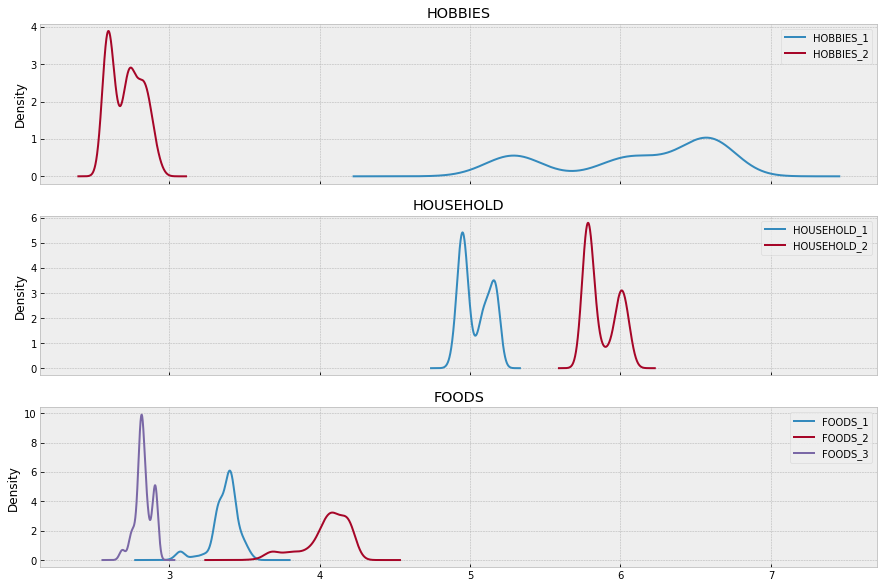

In [14]:
# Distribution of price per department

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0

cats = pd.unique(sell_prices.cat_id)
for cat in cats:
    subset = sell_prices[sell_prices.cat_id==cat].copy()
    subset = subset.groupby(['dept', 'wm_yr_wk'])['sell_price'].mean().reset_index()
    for dept in pd.unique(subset['dept']):
        subset[subset['dept']==dept]['sell_price'].plot.density(alpha=1, ax=axes[ax_idx], title=cat, label=dept)
        axes[ax_idx].legend()

    ax_idx += 1

### Sales

- Similar spike in sales as prices for hobbies but it happend ~half a year later
- Sales for household products has been increasing, opposite to trend in pricing we saw earlier
- Total sales drop near the end of the year (Walmart closes for Christmas)
- Distributions of sales are different across departments and states
- There are days where sales drop to 0 for a some items then go back up (sold out?)
- Spikes in sales every weekend
- Sales for foods and household items go up in Q3 (July - Sept)

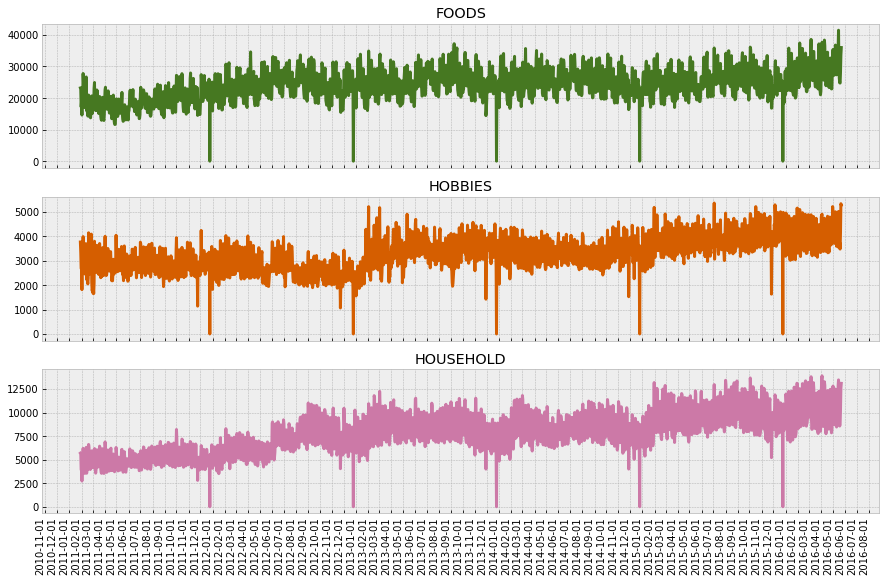

In [15]:
# sum of sales by category

days = [d for d in sales_train.columns if 'd_' in d]
sales_by_cat = sales_train.groupby('cat_id')[days].sum(axis=1).reset_index()
sales_by_cat = sales_by_cat.melt(id_vars='cat_id', value_name='sales', var_name='d')
sales_by_cat = sales_by_cat.merge(calendar[['d','date','wm_yr_wk']], on='d', how='left')

sales_by_cat['date'] = pd.to_datetime(sales_by_cat['date'])

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0

cats = pd.unique(sales_by_cat.cat_id)
for cat in cats:
    subset = sales_by_cat[sales_by_cat.cat_id==cat][['date','sales']].set_index('date')
    #subset = subset.resample('W').sum()
    axes[ax_idx].plot(subset.index.values, subset.sales, alpha=1, lw=3, color=next(color_cycle))
    axes[ax_idx].set_title(cat)
    
    ax_idx += 1
    
date_form = DateFormatter("%Y-%m-%d")
axes[ax_idx-1].xaxis.set_major_formatter(date_form)
axes[ax_idx-1].xaxis.set_major_locator(mdates.MonthLocator())

fig.autofmt_xdate(rotation=90)

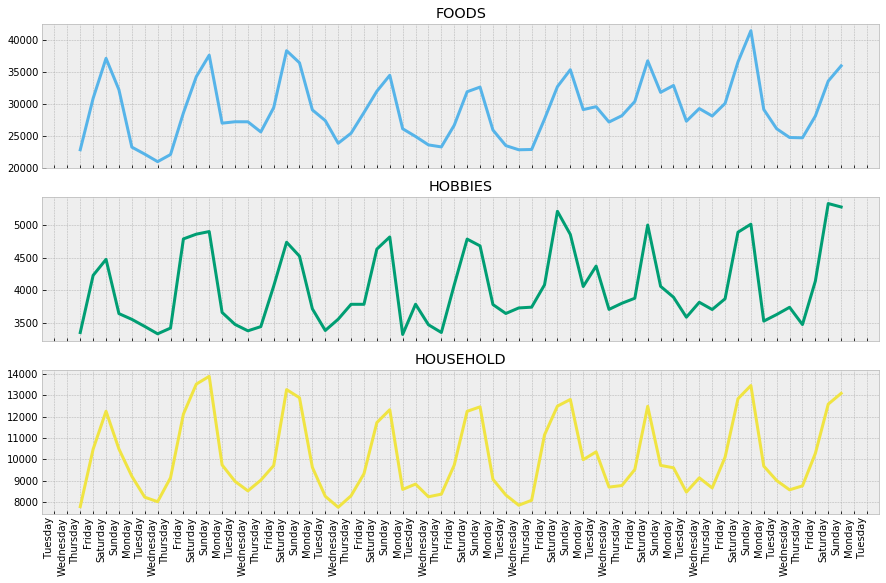

In [16]:
# WEEKEND trends

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0

cats = pd.unique(sales_by_cat.cat_id)
for cat in cats:
    subset = sales_by_cat[sales_by_cat.cat_id==cat][['date','sales']].set_index('date')
    subset = subset.tail(60)
    axes[ax_idx].plot(subset.index.values, subset.sales, alpha=1, lw=3, color=next(color_cycle))
    axes[ax_idx].set_title(cat)
    
    ax_idx += 1

date_form = DateFormatter("%A")
axes[ax_idx-1].xaxis.set_major_formatter(date_form)
axes[ax_idx-1].xaxis.set_major_locator(mdates.DayLocator())

fig.autofmt_xdate(rotation=90)

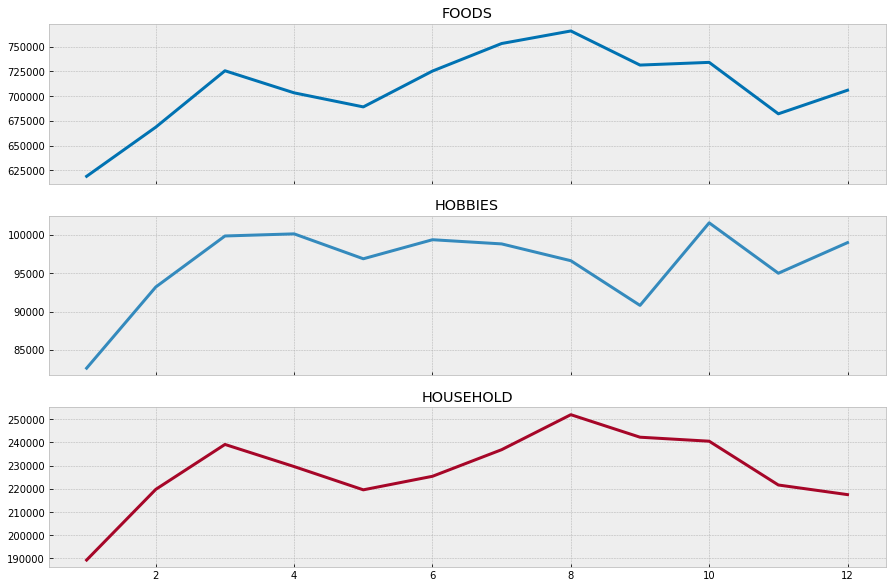

In [17]:
# MONTHLY trends

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0

cats = pd.unique(sales_by_cat.cat_id)
for cat in cats:
    subset = sales_by_cat[sales_by_cat.cat_id==cat][['date','sales']]
    subset['month'] = subset['date'].dt.month
    subset['year'] = subset['date'].dt.year
    subset = subset.groupby(['year','month'])['sales'].sum().reset_index()
    subset = subset.groupby('month')['sales'].mean()
    axes[ax_idx].plot(subset.index.values, subset, alpha=1, lw=3, color=next(color_cycle))
    axes[ax_idx].set_title(cat)
    
    ax_idx += 1

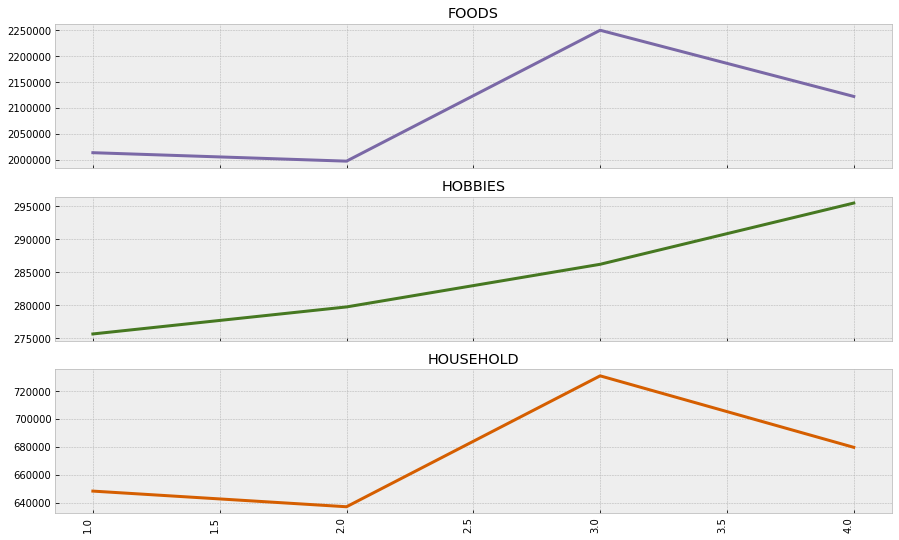

In [18]:
# QUARTERLY trends

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0

cats = pd.unique(sales_by_cat.cat_id)
for cat in cats:
    subset = sales_by_cat[sales_by_cat.cat_id==cat][['date','sales']]
    subset['quarter'] = subset['date'].dt.quarter
    subset['year'] = subset['date'].dt.year
    subset = subset.groupby(['year','quarter'])['sales'].sum().reset_index()
    subset = subset.groupby('quarter')['sales'].mean()
    axes[ax_idx].plot(subset.index.values, subset, alpha=1, lw=3, color=next(color_cycle))
    axes[ax_idx].set_title(cat)
    
    ax_idx += 1

fig.autofmt_xdate(rotation=90)

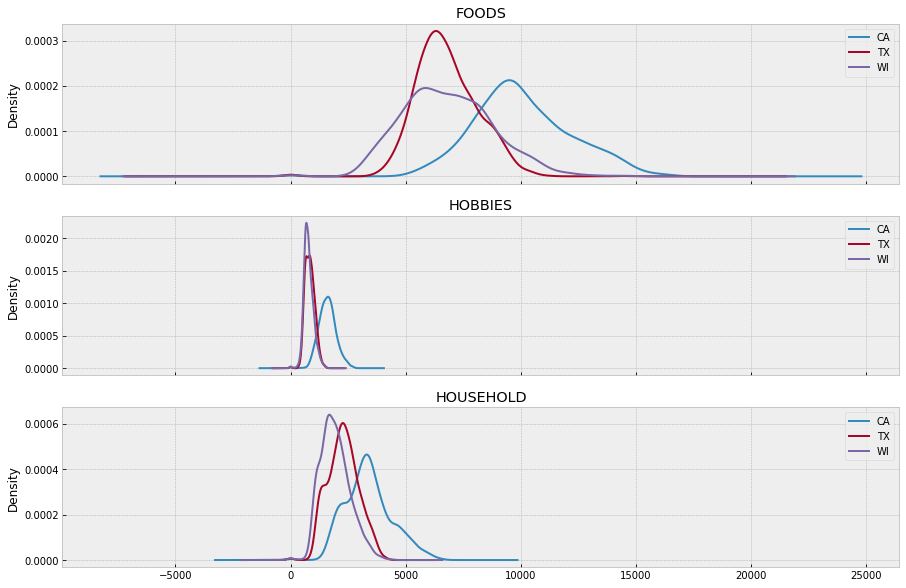

In [19]:
# Distribution of sales by state

days = [d for d in sales_train.columns if 'd_' in d]
sales_by_state= sales_train.groupby(['cat_id','state_id'])[days].sum(axis=1).reset_index()
sales_by_state = sales_by_state.melt(id_vars=['cat_id','state_id'], value_name='sales', var_name='d')
sales_by_state = sales_by_state.merge(calendar[['d','date','wm_yr_wk']], on='d', how='left')

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0

cats = pd.unique(sales_by_state.cat_id)
for cat in cats:
    subset = sales_by_state[sales_by_state.cat_id==cat].copy()
    for state in pd.unique(subset['state_id']):
        subset[subset['state_id']==state]['sales'].plot.density(alpha=1, ax=axes[ax_idx], title=cat, label=state)
        axes[ax_idx].legend()

    ax_idx += 1

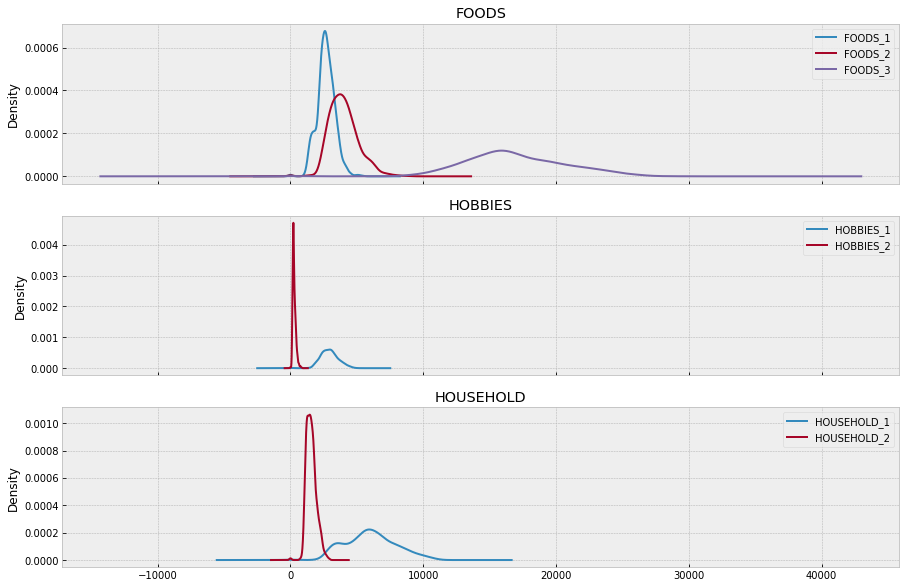

In [20]:
# Distribution of sales by department

days = [d for d in sales_train.columns if 'd_' in d]
sales_by_dept = sales_train.groupby(['cat_id','dept_id'])[days].sum(axis=1).reset_index()
sales_by_dept = sales_by_dept.melt(id_vars=['cat_id','dept_id'], value_name='sales', var_name='d')
sales_by_dept = sales_by_dept.merge(calendar[['d','date','wm_yr_wk']], on='d', how='left')

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0

cats = pd.unique(sales_by_dept.cat_id)
for cat in cats:
    subset = sales_by_dept[sales_by_dept.cat_id==cat].copy()
    for dept in pd.unique(subset['dept_id']):
        subset[subset['dept_id']==dept]['sales'].plot.density(alpha=1, ax=axes[ax_idx], title=cat, label=dept)
        axes[ax_idx].legend()

    ax_idx += 1

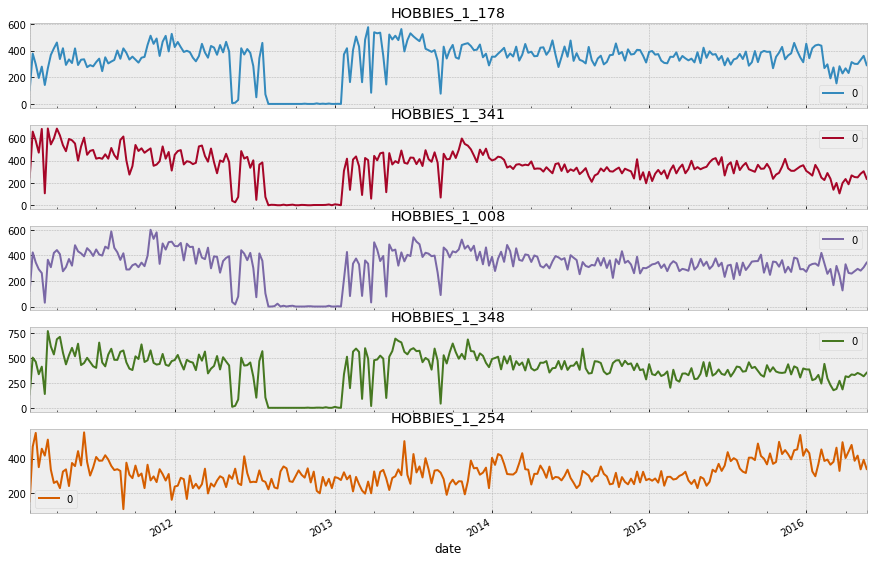

In [22]:
# What does sale pattern looks like for individual items

category = 'HOBBIES'

fig, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0

days = [d for d in sales_train.columns if 'd_' in d]
subset = sales_train[sales_train.cat_id==category]
high_purchase_items = subset.groupby('item_id')[days].sum().sum(axis=1).sort_values(ascending=False)[:10].index
high_purchase_items = random.sample(list(high_purchase_items), k=5)

for item in high_purchase_items:
    popular_item_sales = sales_train[sales_train.item_id==item].sum(axis=0).reset_index()
    popular_item_sales = pd.merge(popular_item_sales, calendar[['d', 'date']].drop_duplicates(), left_on='index', right_on='d')
    popular_item_sales['date'] = pd.to_datetime(popular_item_sales['date'])
    popular_item_sales = popular_item_sales[['date',0]].set_index('date')
    popular_item_sales = popular_item_sales.resample('W').sum()
    popular_item_sales.plot(alpha=1, ax=axes[ax_idx], title=item, color=next(color_cycle))
    ax_idx += 1
    
fig.autofmt_xdate()


### Time Series Analysis

- At Category level, highest correlation where lag is multiple of 7 (as expected since sales go up every weekend)
- At item level, add lag 1 and 7
- Seeing items where lag is significant for the first 10 days only, feature to consider: days since item rolled out

In [24]:
days = [d for d in sales_train.columns if 'd_' in d]
sales_by_cat = sales_train.groupby('cat_id')[days].sum(axis=1).reset_index()
sales_by_cat = sales_by_cat.melt(id_vars='cat_id', value_name='sales', var_name='d')
sales_by_cat = sales_by_cat.merge(calendar[['d','date','wm_yr_wk']], on='d', how='left')

sales_by_cat['date'] = pd.to_datetime(sales_by_cat['date'])

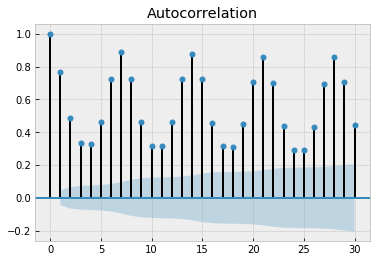

In [28]:
# Display the autocorrelation plot
cat = 'HOUSEHOLD'
fig = tsaplots.plot_acf(sales_by_cat[sales_by_cat.cat_id==cat]['sales'], lags=30)
plt.show()

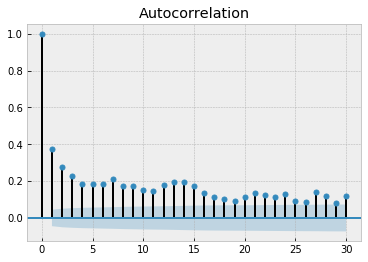

In [67]:
# autocorrelation plot for a random item
# FOODS_2_232_CA_3_validation: this item has correlation in the first 10 days only
# feature to consider: days since item rolled out

item = random.choice(sales_train.id)
df = sales_train[sales_train['id']==item]
cols = [c for c in df.columns if c=='id' or 'd_' in c]
df = df[cols].melt(id_vars='id', value_name='sales', var_name='d')

fig = tsaplots.plot_acf(df['sales'], lags=30)
plt.show()

In [ ]:
# include lags: first 10 days

In [192]:
item = random.choice(sales_train.id)
df = sales_train[sales_train['id']==item]
cols = [c for c in df.columns if c=='id' or 'd_' in c]
df = df[cols].melt(id_vars='id', value_name='sales', var_name='d')

# Use acf to compute serial correlation up to nlags
n = 365
acf = smtsa.acf(df['sales'], nlags=n, unbiased=True)

corr_df = pd.DataFrame()
for i in range(n):
    corr_df = corr_df.append(pd.DataFrame([{'n':i, 'corr':acf[i]}]))

corr_df['divi_7'] = corr_df['n'].mod(7)

corr_df.sort_values(by='corr', ascending=False).head(10)

,corr,n,divi_7
0,1.000000,0,0
0,0.136255,8,1
0,0.126190,38,3
0,0.118873,21,0
0,0.113218,25,4
0,0.113024,18,4
0,0.110014,74,4
0,0.107742,20,6
0,0.105774,90,6
0,0.105295,22,1


### Price & Sales

- positive pearson correlation between sales and change in price in the past 30 days for hobbies and foods, negative for household

In [288]:
days = [d for d in sales_train if 'd_' in d]

sales_by_week = sales_by_cat.groupby(['cat_id', 'wm_yr_wk'])['sales'].sum().reset_index()
prices = sell_prices.groupby(['cat_id','wm_yr_wk'])['sell_price'].mean().reset_index()
sales_and_prices = sales_by_week.merge(prices, on=['cat_id','wm_yr_wk'], how='left')

weekly_dates = calendar.groupby('wm_yr_wk')['date'].min().reset_index()
sales_and_prices = sales_and_prices.merge(weekly_dates, on='wm_yr_wk', how='left')

sales_and_prices["shift_price_t"] = sales_and_prices.groupby(["cat_id"])["sell_price"].transform(lambda x: x.shift(30))
sales_and_prices["change_price_t"] = (sales_and_prices["shift_price_t"] - sales_and_prices["sell_price"]) / (sales_and_prices["shift_price_t"])

pearson corr for FOODS:  0.4663651125865986
pearson corr for HOBBIES:  0.5587542767594806
pearson corr for HOUSEHOLD:  -0.2704438411189591


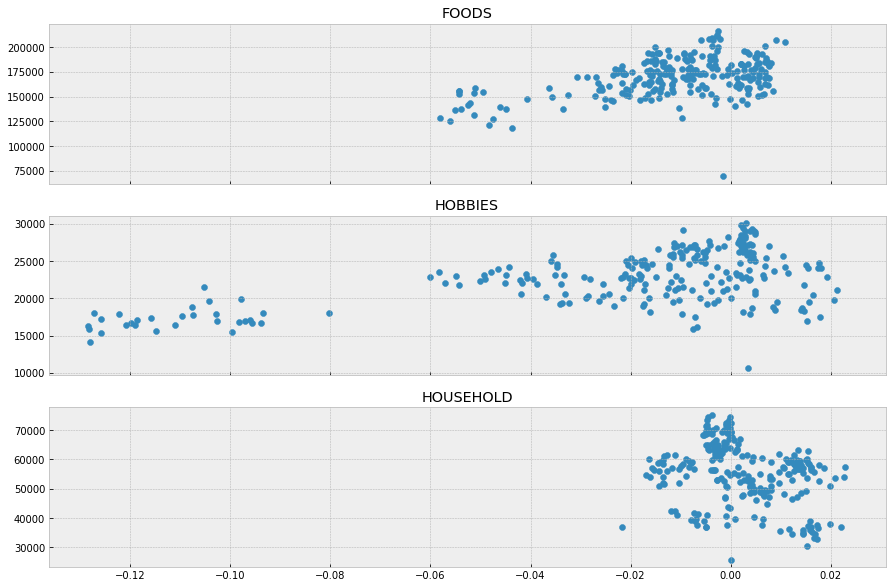

In [326]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0

cats = pd.unique(sales_by_dept.cat_id)
for cat in cats:
    axes[ax_idx].scatter(sales_and_prices[sales_and_prices['cat_id']==cat]['change_price_t'],
                    sales_and_prices[sales_and_prices['cat_id']==cat]['sales'])
    axes[ax_idx].set_title(cat)
    ax_idx += 1

    print(f'pearson corr for {cat}: ', sales_and_prices[sales_and_prices['cat_id']==cat]['change_price_t'].corr(sales_and_prices[sales_and_prices['cat_id']==cat]['sales']))

In [198]:
sell_prices.drop(['cat_id','state','dept'], axis=1, inplace=True)

# Data Prep

In [8]:
# set variables

NUM_ITEMS = sales_train.shape[0]  # 30490
DAYS_PRED = submission.shape[1] - 1  # 28
LAST_DAY = max([int(d.split('_')[1]) for d in sales_train.columns if 'd_' in d])

In [9]:
def reduce_mem_usage(df, verbose=True):

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def encode_categorical(df, cols):
    
    for col in cols:
        # Leave NaN as it is.
        le = LabelEncoder()
        #not_null = df[col][df[col].notnull()]
        df[col] = df[col].fillna('nan')
        df[col] = pd.Series(le.fit_transform(df[col]), index=df.index)

    return df

In [10]:
# encode and change datatype to reduce memory usage
calendar = encode_categorical(calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]).pipe(reduce_mem_usage)
sales_train = encode_categorical(sales_train, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],).pipe(reduce_mem_usage)
sell_prices = encode_categorical(sell_prices, ["item_id", "store_id"]).pipe(reduce_mem_usage)

Mem. usage decreased to  0.07 Mb (66.9% reduction)
Mem. usage decreased to 95.37 Mb (79.0% reduction)
Mem. usage decreased to 45.67 Mb (78.1% reduction)


In [11]:
# Fill first few days where demands == 0 as nan

d_name = [c for c in sales_train.columns if 'd_' in c]
sales_train_val_values = sales_train[d_name].values

# calculate the start position(first non-zero demand observed date) for each item 
tmp = np.tile(np.arange(1,LAST_DAY+1),(sales_train_val_values.shape[0],1))
# 0 if sales value is 0 else fille with day number
df_tmp = ((sales_train_val_values>0) * tmp)

# flag the first day where demand is non-zero
start_no = np.min(np.where(df_tmp==0,9999,df_tmp),axis=1)-1
flag = np.dot(np.diag(1/(start_no+1)) , tmp)<1

sales_train_val_values = np.where(flag,np.nan,sales_train_val_values)

sales_train[d_name] = sales_train_val_values

del tmp,sales_train_val_values
gc.collect()

0

In [12]:
# melt dataframe so 1 row is each day
sales_train = pd.melt(sales_train, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                      var_name='day', value_name='demand')

In [13]:
# performance improves when train on just the past 2 years
# might be because of outliers or recent data is just more predictive
nrows = 365 * 2 * NUM_ITEMS
sales_train = sales_train.iloc[-nrows:,:]
# remove and demand is null
sales_train = sales_train[~sales_train.demand.isnull()]

In [14]:
# merging with calendar and price

calendar['date'] = calendar['date'].astype('datetime64[D]')
calendar.drop(['weekday', 'wday', 'month', 'year'], 
              inplace = True, axis = 1)

sales_train = pd.merge(sales_train, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
sales_train.drop(['d', 'day'], inplace = True, axis = 1)

# get the sell price data (this feature should be very important)
sales_train = sales_train.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
print('Our final dataset to train has {} rows and {} columns'.format(sales_train.shape[0], sales_train.shape[1]))

Our final dataset to train has 21797534 rows and 17 columns


## Train Val Test Split

Label sections of the full dataset as train, validation, test (public score), and prediction (private score)

In [15]:
# section out train, validation, test
sales_train['date'] = sales_train['date'].dt.date
sales_train['section'] = 'train'

all_dates = pd.unique(sales_train.date)
test_dates = [d for d in all_dates if d > max(all_dates) - datetime.timedelta(days=DAYS_PRED*2)]
train_dates = list(set(all_dates) - set(test_dates))
val_dates, test_dates = test_dates[:DAYS_PRED], test_dates[DAYS_PRED:]

sales_train.loc[sales_train.date.isin(val_dates), 'section'] = 'validation'
sales_train.loc[sales_train.date.isin(test_dates), 'section'] = 'test'

In [16]:
# create predict dataset
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['date'] = calendar['date'].dt.date
calendar = calendar[calendar['date']>np.max(test_dates)]

prices = sell_prices[sell_prices.wm_yr_wk.isin(calendar.wm_yr_wk)].copy()
prices = prices.merge(calendar, on='wm_yr_wk')

pred_df = prices.merge(sales_train[['id','store_id','item_id','dept_id','cat_id','state_id']].drop_duplicates(), on=['store_id','item_id'])
pred_df['demand'] = np.nan
pred_df['section'] = 'prediction'
pred_df = pred_df[sales_train.columns]

sales_train = sales_train.append(pred_df)

del pred_df
del prices

In [34]:
sales_train['date'] = pd.to_datetime(sales_train['date'])

In [18]:
gc.collect()

150

# Feature Engineering

In [19]:
attrs = [
    "year",
    "quarter",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_year_end",
    "is_year_start",
    "is_quarter_end",
    "is_quarter_start",
    "is_month_end",
    "is_month_start",
]

for attr in attrs:
    dtype = np.int16 if attr == "year" else np.int8
    sales_train[attr] = getattr(sales_train['date'].dt, attr).astype(dtype)

sales_train["is_weekend"] = sales_train["dayofweek"].isin([5, 6]).astype(np.int8)

In [20]:
# price lags

sales_train["shift_price_t1"] = sales_train.groupby(["id"])["sell_price"].transform(lambda x: x.shift(1))
sales_train["price_change_t1"] = (sales_train["shift_price_t1"] - sales_train["sell_price"]) / (sales_train["shift_price_t1"])

sales_train["shift_price_t30"] = sales_train.groupby(["id"])["sell_price"].transform(lambda x: x.shift(30))
sales_train["price_change_t30"] = (sales_train["shift_price_t30"] - sales_train["sell_price"]) / (sales_train["shift_price_t30"])

sales_train["cat_shift_price_t30"] = sales_train.groupby(["cat_id"])["sell_price"].transform(lambda x: x.shift(30))
sales_train["cat_change_price_t30"] = (sales_train["cat_shift_price_t30"] - sales_train["sell_price"]) / (sales_train["cat_shift_price_t30"])


sales_train["rolling_price_max_t365"] = sales_train.groupby(["id"])["sell_price"].transform(
    lambda x: x.shift(1).rolling(365).max())

sales_train["price_change_t365"] = (sales_train["rolling_price_max_t365"] - sales_train["sell_price"]) / (
    sales_train["rolling_price_max_t365"])

sales_train["rolling_price_std_t7"] = sales_train.groupby(["id"])["sell_price"].transform(
    lambda x: x.rolling(7).std())

sales_train["rolling_price_std_t30"] = sales_train.groupby(["id"])["sell_price"].transform(
    lambda x: x.rolling(30).std())

In [21]:
# demand lags

for size in [7, 30, 60, 90, 180]:
    sales_train[f"demand_rolling_mean_t{size}"] = sales_train.groupby(["id"])["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(size).mean()
    )

for diff in [0, 1, 2]:
    shift = DAYS_PRED + diff
    sales_train[f"demand_shift_t{shift}"] = sales_train.groupby(["id"])["demand"].transform(
        lambda x: x.shift(shift)
    )
    
sales_train["demand_change_t30"] = (sales_train["demand_shift_t30"] - sales_train["demand_shift_t28"]) / (sales_train["demand_shift_t30"])

In [22]:
# event lags

sales_train["shift_event_type1_t7"] = sales_train.groupby(["id"])["event_type_1"].transform(lambda x: x.shift(7))
sales_train["shift_event_type1_tminus7"] = sales_train.groupby(["id"])["event_type_1"].transform(lambda x: x.shift(-7))

sales_train["shift_event_type2_t7"] = sales_train.groupby(["id"])["event_type_2"].transform(lambda x: x.shift(7))
sales_train["shift_event_type2_tminus7"] = sales_train.groupby(["id"])["event_type_2"].transform(lambda x: x.shift(-7))

## External Data

### us price index

In [35]:
price_index = pd.read_csv('CPIAUCSL.csv')

price_index.columns = ['date','price_index']
price_index['date'] = pd.to_datetime(price_index['date'])
price_index['date'] = price_index['date'].dt.date

# previous month index
price_index['prev_month_price_index'] = price_index['price_index'].shift(1)
price_index['two_month_price_index'] = price_index['price_index'].shift(2)
price_index['price_index_pc_change'] = (price_index['two_month_price_index'] - price_index['prev_month_price_index'])/price_index['two_month_price_index']

price_index = price_index.set_index('date')
idx = pd.date_range(price_index.index.min(), price_index.index.max())
price_index.index = pd.DatetimeIndex(price_index.index)
price_index = price_index.reindex(idx)

price_index = price_index.reset_index()
price_index.rename({'index':'date'}, axis=1, inplace=True)

price_index = price_index.ffill()
del price_index['price_index']

In [36]:
sales_train = sales_train.merge(price_index, on='date', how='left')

### Unemployment rate

In [37]:
states = ['CA','TX','WI']
unemployment_df = pd.DataFrame()
for state in states:
    unemployment = pd.read_csv(f'{state}UR.csv')
    unemployment.columns = ['date','unemployment_rate']
    # previous month index
    unemployment['prev_month_ur'] = unemployment['unemployment_rate'].shift(1)
    unemployment['two_month_ur'] = unemployment['unemployment_rate'].shift(2)
    unemployment['ur_pc_change'] = (unemployment['two_month_ur'] - unemployment['prev_month_ur'])/unemployment['two_month_ur']
    
    unemployment = unemployment.set_index('date')
    idx = pd.date_range(unemployment.index.min(), unemployment.index.max())
    unemployment.index = pd.DatetimeIndex(unemployment.index)
    unemployment = unemployment.reindex(idx)

    unemployment = unemployment.reset_index()
    unemployment.rename({'index':'date'}, axis=1, inplace=True)
    unemployment = unemployment.ffill()
    unemployment['state_id'] = state
    unemployment_df = unemployment_df.append(unemployment)
    
del unemployment_df['unemployment_rate']

state_id_map = {'CA':0, 'TX':1, 'WI':2}
unemployment_df.replace({"state_id": state_id_map}, inplace=True)

In [38]:
sales_train = sales_train.merge(unemployment_df, on=['date','state_id'], how='left')

### Walmart Stock

In [39]:
min_dt = sales_train.date.min() - datetime.timedelta(days=1)
max_dt = sales_train.date.max()

In [40]:
stock_df = pd.read_csv('HistoricalQuotes.csv')

stock_df.columns = ['date','close','volume','open','high','low']

for col in ['close','open','high','low']:
    stock_df[col] = stock_df[col].str.replace('$','')
    stock_df[col] = stock_df[col].astype(float)
    

stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df['date'] = stock_df['date'].dt.date

stock_df = stock_df[(stock_df['date']>=min_dt.date()) & (stock_df['date']<=max_dt.date())]
stock_df = stock_df.sort_values(by='date')
stock_df = stock_df.set_index('date')

idx = pd.date_range(min_dt.strftime('%d.%m.%Y'), max_dt.strftime('%d.%m.%Y'))
stock_df.index = pd.DatetimeIndex(stock_df.index)
stock_df = stock_df.reindex(idx)

stock_df = stock_df.reset_index()
stock_df.rename({'index':'date'}, axis=1, inplace=True)

# forward fill for weekend
stock_df = stock_df.ffill()

stock_cols = ['open','high','low','close','volume']
for col in stock_cols:
    for n in [1, 7]:
        stock_df[f"shift_{col}_t{n}"] = stock_df[col].transform(lambda x: x.shift(n))

for col in stock_cols:
    stock_df[f"shift_{col}_t14"] = stock_df[col].transform(lambda x: x.shift(14))
    stock_df[f"{col}_change_t7"] = (stock_df[f"shift_{col}_t14"] - stock_df[f"shift_{col}_t7"]) / (stock_df[f"shift_{col}_t14"])
    
stock_df.drop(stock_cols, axis=1, inplace=True)

In [41]:
sales_train = sales_train.merge(stock_df, on='date', how='left')

# Evaluation Metric

M5 uses Weighted Root Mean Squared Scaled Error (WRMSSE), which is a weighted variant of Mean Absolute Scaled Error (MASE). The RMSSE is calculated for all 42,480 time series and weighted by the accumulated dollar sales of each series over the last 28 days of the training dataset. 

For more details, please go to the competition page.


In [23]:
def weight_calc(data):
    """
    calculate the denominator of RMSSE, and calculate the weight base on sales amount
    """
    
    zf = zipfile.ZipFile('sales_train_validation.csv.zip')
    sales_train_val = pd.read_csv(zf.open('sales_train_validation.csv'))
    
    product = sales_train_val[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

    zf = zipfile.ZipFile('sales_train_evaluation.csv.zip')
    sales_train_eval = pd.read_csv(zf.open('sales_train_evaluation.csv'))

    missing_days = sorted(list(set([d for d in sales_train_eval.columns if 'd_' in d]) -  set([d for d in sales_train_val.columns if 'd_' in d])))
    sales_train_eval = sales_train_eval[['id'] + missing_days]
    sales_train_eval['id'] = sales_train_eval['id'].str.replace('evaluation','validation')
    sales_train_val = sales_train_val.merge(sales_train_eval, on='id', how='left')
    del sales_train_eval
    gc.collect()
    
    # initialize weight mat for each level of aggregation
    # dimension: (# of series, # products)
    weight_mat = np.c_[np.ones([NUM_ITEMS,1]).astype(np.int8), # level 1
                       pd.get_dummies(product.state_id.astype(str),drop_first=False).astype('int8').values,
                       pd.get_dummies(product.store_id.astype(str),drop_first=False).astype('int8').values,
                       pd.get_dummies(product.cat_id.astype(str),drop_first=False).astype('int8').values,
                       pd.get_dummies(product.dept_id.astype(str),drop_first=False).astype('int8').values,
                       pd.get_dummies(product.state_id.astype(str) + product.cat_id.astype(str),drop_first=False).astype('int8').values,
                       pd.get_dummies(product.state_id.astype(str) + product.dept_id.astype(str),drop_first=False).astype('int8').values,
                       pd.get_dummies(product.store_id.astype(str) + product.cat_id.astype(str),drop_first=False).astype('int8').values,
                       pd.get_dummies(product.store_id.astype(str) + product.dept_id.astype(str),drop_first=False).astype('int8').values,
                       pd.get_dummies(product.item_id.astype(str),drop_first=False).astype('int8').values,
                       pd.get_dummies(product.state_id.astype(str) + product.item_id.astype(str),drop_first=False).astype('int8').values,
                       np.identity(NUM_ITEMS).astype(np.int8) #item :level 12
                       ].T

    # free up memory
    weight_mat_csr_ = csr_matrix(weight_mat)
    del weight_mat; gc.collect()

    d_name = [c for c in sales_train_val.columns if 'd_' in c]
    sales_train_val = weight_mat_csr_ * sales_train_val[d_name].values

    # calculate the start position(first non-zero demand observed date) for each item
    df_tmp = ((sales_train_val>0) * np.tile(np.arange(1, LAST_DAY+1), (weight_mat_csr_.shape[0],1)))
    start_no = np.min(np.where(df_tmp==0, 9999, df_tmp),axis=1)-1
    flag = np.dot(np.diag(1/(start_no+1)) , np.tile(np.arange(1,LAST_DAY+1),(weight_mat_csr_.shape[0],1)))<1
    sales_train_val = np.where(flag,np.nan, sales_train_val)

    # denominator of RMSSE / RMSSE
    weight1 = np.nansum(np.diff(sales_train_val,axis=1)**2,axis=1)/(LAST_DAY-start_no)

    # calculate the sales amount for each item/level
    # weight of each series calculated based on the last 28 observation of the training dataset

    data['date'] = data['date'].dt.date
    df_tmp = data[(data['date'] > datetime.date(2016,3,27)) & 
                  (data['date'] <= datetime.date(2016,4,24))].copy()
    df_tmp['amount'] = df_tmp['demand'] * df_tmp['sell_price']
    df_tmp = df_tmp.groupby(['id'])['amount'].apply(np.sum)
    df_tmp = df_tmp[product.id].values
    
    weight2 = weight_mat_csr_ * df_tmp 
    weight2 = weight2/np.sum(weight2)

    del sales_train_val
    gc.collect()
    
    return weight_mat_csr_, weight1, weight2


def wrmsse(preds, data, raw=True):
    
    # this function is calculate for last 28 days to consider the non-zero demand period
    if raw:
        y_true = data.get_label()
    else:
        y_true = data.copy()

    y_true = y_true[-(NUM_ITEMS * DAYS_PRED):]
    preds = preds[-(NUM_ITEMS * DAYS_PRED):]
    # number of columns
    num_col = DAYS_PRED
    
    # reshape data to original array((NUM_ITEMS*num_col,1)->(NUM_ITEMS, num_col) )
    reshaped_preds = preds.reshape(num_col, NUM_ITEMS).T
    reshaped_true = y_true.reshape(num_col, NUM_ITEMS).T

    train = weight_mat_csr*np.c_[reshaped_preds, reshaped_true]
    
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,:num_col] - train[:,num_col:])
                        ,axis=1) / weight1) * weight2)
    
    return 'wrmsse', score, False

In [24]:
weight_mat_csr, weight1, weight2 = weight_calc(sales_train)

# Model

In [47]:
train_df, val_df, test_df, pred_df = sales_train[sales_train.section=='train'], \
                                     sales_train[sales_train.section=='validation'],\
                                     sales_train[sales_train.section=='test'],\
                                     sales_train[sales_train.section=='prediction']

## Baseline Model (Moving Average)

- Using 30 day moving average of the train and validation sets to predict test set
- Baseline WRMSSE is 0.73

In [26]:
predictions = sales_train[sales_train.section.isin(['train','validation'])].groupby('id')['demand'].rolling(30).mean().reset_index()
predictions = predictions.groupby('id').tail(1)
predictions = predictions.drop('level_1', axis=1)
predictions.rename(columns={'demand':'pred_demand'}, inplace=True)

test_df = test_df.merge(predictions, on='id')
del predictions

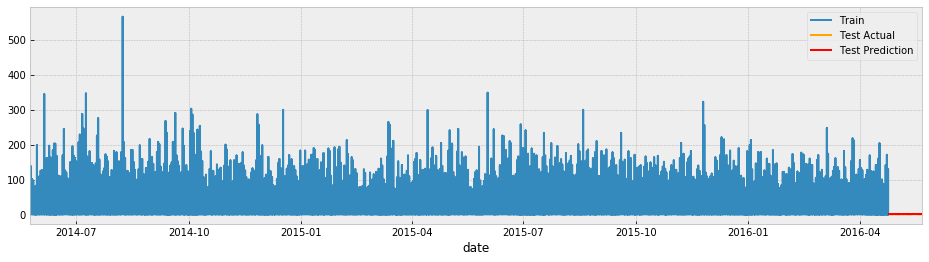

In [27]:
# plot prediction against actual
random_item = random.choice(pd.unique(test_df['id']))
plt.figure(figsize=(16,4))

sales_train[sales_train.section.isin(['train','validation'])].set_index('date')['demand'].plot(label='Train')
test_df[(test_df['id']==random_item)].set_index('date')['demand'].plot(label='Test Actual', color='orange')
test_df[test_df['id']==random_item].set_index('date')['pred_demand'].plot(label='Test Prediction', color='red')
plt.legend()
plt.show()

In [31]:
print('wrmsse:',wrmsse(np.array(test_df['pred_demand']), np.array(test_df['demand']), raw=False))

In [29]:
del test_df['pred_demand']

## Light GBM

In [48]:
target = 'demand'
features = [c for c in sales_train.columns if c not in [target, 'date', 'id', 'section']]

In [49]:
y_train = train_df[[target]]
x_train = train_df[features]

x_valid = val_df[features]
y_valid = val_df[[target]]

x_test = test_df[features]
y_test = test_df[[target]]

In [50]:
d_train = lgb.Dataset(x_train, label=y_train)
d_valid = lgb.Dataset(x_valid, label=y_valid)
d_test = lgb.Dataset(x_test, label=y_test)

In [51]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'custom',
    'objective': 'poisson',
    'n_jobs': -1,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10, 
    'colsample_bytree': 0.75,
    "num_threads":80,
    'num_leaves':700,
    'min_data_in_leaf':300,
    'num_iterations':500,
    'max_bin':500,
    'lambda_l2':2
}

model = lgb.train(params,
                  d_train,
                  valid_sets = [d_train, d_test],
                  num_boost_round=2500, 
                  early_stopping_rounds=20,
                  feval=wrmsse
                 )

/usr/local/anaconda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's wrmsse: 2.17213	valid_1's wrmsse: 2.22762
Training until validation scores don't improve for 20 rounds
[2]	training's wrmsse: 2.08115	valid_1's wrmsse: 2.13396
[3]	training's wrmsse: 1.99763	valid_1's wrmsse: 2.04587
[4]	training's wrmsse: 1.92685	valid_1's wrmsse: 1.97162
[5]	training's wrmsse: 1.85173	valid_1's wrmsse: 1.89524
[6]	training's wrmsse: 1.78275	valid_1's wrmsse: 1.82348
[7]	training's wrmsse: 1.71748	valid_1's wrmsse: 1.7559
[8]	training's wrmsse: 1.65536	valid_1's wrmsse: 1.6919
[9]	training's wrmsse: 1.59615	valid_1's wrmsse: 1.63103
[10]	training's wrmsse: 1.54131	valid_1's wrmsse: 1.57417
[11]	training's wrmsse: 1.48987	valid_1's wrmsse: 1.52133
[12]	training's wrmsse: 1.44124	valid_1's wrmsse: 1.47058
[13]	training's wrmsse: 1.39563	valid_1's wrmsse: 1.42334
[14]	training's wrmsse: 1.34982	valid_1's wrmsse: 1.37632
[15]	training's wrmsse: 1.30749	valid_1's wrmsse: 1.33336
[16]	training's wrmsse: 1.26798	valid_1's wrmsse: 1.29214
[17]	training's wrmsse

In [52]:
pred = model.predict(x_test)
print('wrmsse', wrmsse(np.array(pred), np.array(y_test), raw=False))

wrmsse ('wrmsse', 0.5769560755132572, False)


# Shapley

In [39]:
import shap

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(x_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
shap.summary_plot(shap_values, x_train)

# Submission

In [59]:
# create submission file for kaggle

eval_predictions = pred_df.copy()
eval_predictions['demand'] = model.predict(pred_df[features])
eval_predictions = eval_predictions[['id', 'date', 'demand']]
eval_predictions = pd.pivot(eval_predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
eval_predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
eval_predictions['id'] = eval_predictions['id'].str.replace('validation','evaluation')

valid_predictions = test_df.copy()
valid_predictions['demand'] = pred
valid_predictions = valid_predictions[['id', 'date', 'demand']]
valid_predictions = pd.pivot(valid_predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
valid_predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

final = pd.concat([valid_predictions, eval_predictions])
final.to_csv('submission_late.csv', index=False)